
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi 

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions: 
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [1]:
#########################################
# TODO: Enter your personal information #
#########################################

student_name = "Muhammad Erfan Bagherinejad" # Replace with your name
student_id   = 402200359  # Replace with your student ID

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: Muhammad Erfan Bagherinejad
Your student ID: 402200359


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [2]:
# !pip install datasets

Required Libraries:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset

%matplotlib inline

#####################################################################
# TODO: Add any additional libraries you may need for your analysis #
#####################################################################
 
# You can add your libraries here
import pandas as pd
import nltk
from nltk.tokenize import TweetTokenizer
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay

nltk.download('punkt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

C:\Users\moham\AppData\Roaming\Python\Python312\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\moham\AppData\Roaming\Python\Python312\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Error loading punkt: <urlopen error [WinError 10061] No
[nltk_data]     connection could be made beca

device(type='cuda')

### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [3]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs), hist.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs), hist.history.get('loss'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [4]:
dataset = load_dataset('emotion')
dataset

Using the latest cached version of the dataset since emotion couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'split' at C:\Users\moham\.cache\huggingface\datasets\emotion\split\0.0.0\cab853a1dbdf4c42c2b3ef2173804746df8825fe (last modified on Sat Dec 21 23:07:46 2024).


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# Display the first few samples
# print(dataset['train'][0:5])  # Adjust 'train' to 'test' or other splits if necessary
fealings = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for i in range(20):
    print(f"text: {dataset['train']['text'][i]}, label: {fealings[dataset['train']['label'][i]]}")

text: i didnt feel humiliated, label: sadness
text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake, label: sadness
text: im grabbing a minute to post i feel greedy wrong, label: anger
text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property, label: love
text: i am feeling grouchy, label: anger
text: ive been feeling a little burdened lately wasnt sure why that was, label: sadness
text: ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny, label: surprise
text: i feel as confused about life as a teenager or as jaded as a year old man, label: fear
text: i have been with petronas for years i feel that petronas has performed well and made a huge profit, label: joy
text: i feel romantic too, label: love
text: i feel like i have to make the suffering i m seeing mean something, label: sadness
text: i do feel that running 

In [6]:
###########################################################################
# TODO: Create variables for the training, validation, and test datasets. #
###########################################################################

training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [7]:
########################################################################################################
# TODO:                                                                                                #
# Implement the `extract_tweets_labels` function to iterate over the provided dataset.                 #
# Within this function, extract the tweet text and their corresponding labels into two separate lists. #
# Then, call this function with the training dataset to obtain the tweets and labels,                  #
# ensuring proper data handling for subsequent analysis.                                               #
########################################################################################################

def extract_tweets_labels(data):
    # Extract the text and labels from the data
    tweets = data['text']
    labels = data['label']
    return tweets, labels

# Get the tweets and labels from the training set
tweets, labels = extract_tweets_labels(training)

# Display the first tweet and its label
print(tweets[0], labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [8]:
###############################################################################################################################################
# TODO: Tokenization of Tweets                                                                                                                #
# 1. Select a Tokenization Method: Choose a suitable tokenization method to preprocess the tweets.                                            #                                 
# Ensure that the tokenization handles special characters and maintains the integrity of the text data.                                       #
# 2. Implement the Tokenizer: Once you have selected a method, implement the tokenizer to convert the tweet texts into sequences of tokens.   #
# 3. Test the Tokenization:                                                                                                                   #
# Verify the functionality of your tokenizer by applying it to a sample tweet from the dataset and displaying the resulting tokenized output. #
###############################################################################################################################################

# 1. Select Tokenization Method: Using `nltk.TweetTokenizer`
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

test_txt = tweets[10]
print(f'text: {test_txt}\ntokenized: {tokenizer.tokenize(test_txt)}')


text: i feel like i have to make the suffering i m seeing mean something
tokenized: ['i', 'feel', 'like', 'i', 'have', 'to', 'make', 'the', 'suffering', 'i', 'm', 'seeing', 'mean', 'something']


---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


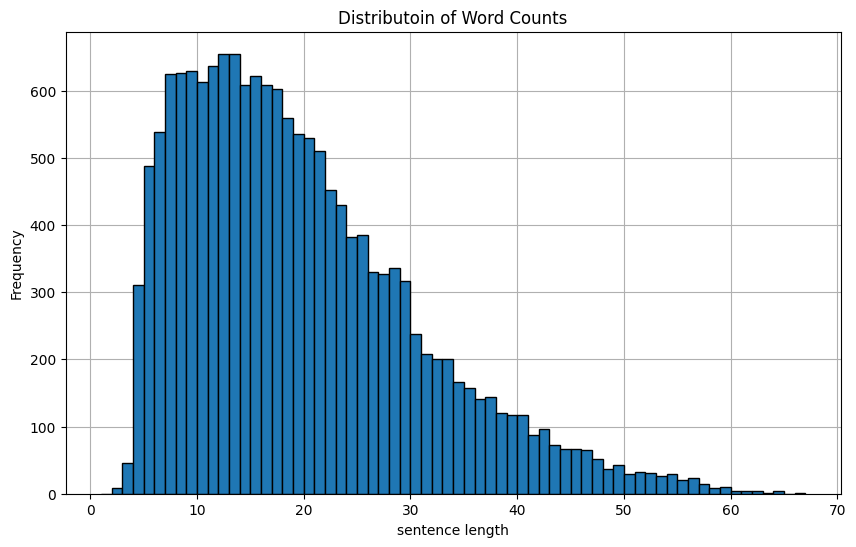

The value greater than 98% of the data is: 48


In [9]:
#####################################################################################################################################################
# TODO:                                                                                                                                             #
# Implement code to calculate the lengths of the tweets and visualize the distribution using a histogram. Use an appropriate visualization library. #
# After visualizing the distribution, determine a suitable maximum length for padding and truncating the sequences based on your findings.          #
#####################################################################################################################################################
word_count = [len(tweet.split()) for tweet in tweets]

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(word_count, 
         bins=range(1, max(word_count) + 2),
         zorder=2, 
         edgecolor='black')
plt.title('Distributoin of Word Counts')
plt.xlabel('sentence length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Calculate the percentile value
p = 98
maximum_length = int(np.percentile(word_count, p))
print(f"The value greater than {p}% of the data is: {maximum_length}")

In [10]:
############################################################################################################
# TODO: Define a function to convert the tokenized tweets into sequences and apply padding and truncation. # 
# Use your determined maximum length for padding the sequences.                                            #
############################################################################################################ 

# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

# Txt2Loader Class
class Txt2Loader:
    def __init__(self, tokenizer, lemmatize=False, maximum_length=48):
        self.tokenizer = tokenizer
        self.lemmatize = lemmatize
        self.maximum_length = maximum_length
        self.vocab = None
        self.vocab_size = None

    def create_tokenized_tweets(self, tweets):
        """Tokenize and pad/lemmatize tweets."""
        nlp = spacy.load("en_core_web_sm") if self.lemmatize else None
        pad_ = '<PAD>'
        
        if self.lemmatize:
            tweets = [" ".join([token.lemma_ for token in nlp(tweet)]) for tweet in tweets]
        
        tokenized_tweets = [self.tokenizer.tokenize(tweet) for tweet in tweets]
        padded_sequences = [
            tweet[:self.maximum_length] + [pad_] * max(0, self.maximum_length - len(tweet))
            for tweet in tokenized_tweets
        ]
        return padded_sequences

    def create_vocab(self, text):
        """Build vocabulary from tokenized and padded text."""
        padded_sequences = self.create_tokenized_tweets(text)
        self.vocab = build_vocab_from_iterator(padded_sequences, specials=['<PAD>'])
        self.vocab.set_default_index(self.vocab['<PAD>'])  # Handle unknown tokens
        self.vocab_size = len(self.vocab)

    def token2num(self, text):
        """Convert tokenized text to numerical indices."""
        if self.vocab is None:
            raise ValueError("Vocabulary is not created. Call `create_vocab` first.")
        
        padded_sequences = self.create_tokenized_tweets(text)
        return [[self.vocab[token] for token in tweet] for tweet in padded_sequences]

    def create_loader(self, text, labels, batch_size, shuffle=True):
        """Create a DataLoader for the dataset."""
        numericalized_tweets = self.token2num(text)
        dataset = SequenceDataset(numericalized_tweets, labels)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [11]:
all_tweets = []
for t in [training , validation ,  test]:
    tweet, _ = extract_tweets_labels(t)
    all_tweets += tweet
loader = Txt2Loader(tokenizer, lemmatize=True, maximum_length=maximum_length)

# Create vocab dictionary
loader.create_vocab(all_tweets)

In [ ]:
# Create training data loader for training process
train_loader = loader.create_loader(tweets, labels, batch_size=256)

---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

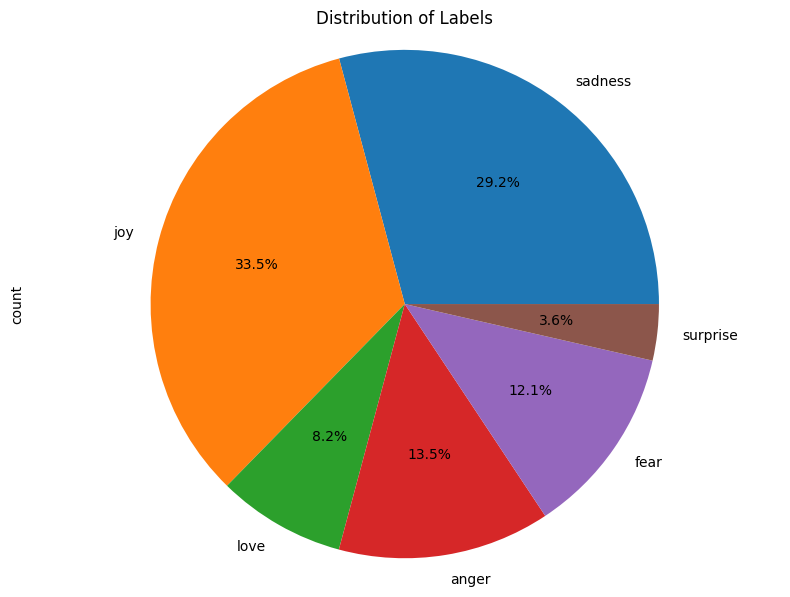

In [13]:
##########################################################################################################################
# TODO: Analyze the distribution of labels in the training set. (visualize it in a perfect way)                          #
# Determine if there is any class imbalance.                                                                             #
# If you observe any imbalance, apply one of the techniques you have learned throughout the course to address the issue. #
##########################################################################################################################
plt.figure(figsize=(8, 6))
label_count = [labels.count(i) for i in range(len(fealings))]
plt.pie(label_count, labels=fealings, autopct='%1.1f%%')
plt.ylabel('count')
plt.title('Distribution of Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

Addressing class imbalance in text classification using RNN models requires a comprehensive strategy to ensure the model learns effectively from all classes, including the minority class. Here are **effective methods**, along with clear justifications:

---

### 1. **Data-Level Solutions**
Modifying the training dataset to balance the class distribution.

#### **a. Oversampling the Minority Class**
- **Description**: Duplicate samples of the minority class or apply data augmentation techniques such as synonym replacement, back-translation, or paraphrasing to create new samples.
- **Why Effective**:
  - Provides more instances of the minority class, ensuring the RNN learns sufficient features.
  - Augmentation reduces overfitting caused by duplicating the same samples.
- **Considerations**: Over-representation of synthetic data can introduce noise if not carefully implemented.

#### **b. Undersampling the Majority Class**
- **Description**: Randomly remove some samples from the majority class to balance the dataset.
- **Why Effective**:
  - Prevents the model from focusing disproportionately on the majority class.
- **Considerations**: Reduces the amount of available training data, which can lead to underfitting.

#### **c. Synthetic Data Generation (e.g., SMOTE for Text Data)**
- **Description**: Use advanced techniques like **SMOTE-Tomek** or **BERT embeddings** to interpolate between minority class samples, creating synthetic examples.
- **Why Effective**:
  - Avoids simple duplication and generates meaningful, realistic new samples.
- **Considerations**: Requires embeddings or additional computational resources.

---

### 2. **Algorithm-Level Solutions**
Modifying the model training process to handle imbalance.

#### **a. Class Weighting**
- **Description**: Assign higher weights to the minority class during the loss computation.
- **Why Effective**:
  - Penalizes misclassifications in the minority class more heavily, encouraging the model to focus on learning its features.
- **Considerations**: Requires accurate computation of class weights; very high weights can lead to instability in training.

#### **b. Focal Loss**
- **Description**: A variant of cross-entropy loss that emphasizes hard-to-classify examples (commonly used in imbalance scenarios).
  ```python
  def focal_loss(gamma=2., alpha=0.25):
      def loss_fn(y_true, y_pred):
          y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
          cross_entropy = -y_true * tf.math.log(y_pred)
          loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
          return tf.reduce_mean(loss)
      return loss_fn
  ```
- **Why Effective**:
  - Focuses more on minority class samples by reducing the contribution of well-classified examples.
- **Considerations**: Requires careful tuning of the `gamma` and `alpha` hyperparameters.

#### **c. Balanced Batch Sampling**
- **Description**: Ensure that each training batch contains an equal number of samples from each class.
  - For example, randomly oversample minority class samples within each batch.
- **Why Effective**:
  - Prevents the model from being exposed to a disproportionately large number of majority class examples.
- **Considerations**: May increase training time due to re-sampling.

---

### 3. **Evaluation-Level Adjustments**
Assess the model's performance using metrics that reflect the imbalance.

#### **a. Use Precision, Recall, and F1-Score**
- **Why Effective**:
  - These metrics are more informative than accuracy in imbalanced datasets, as they evaluate performance on both classes independently.

#### **b. ROC-AUC**
- **Why Effective**:
  - Provides a measure of the model's ability to distinguish between classes, even when the dataset is imbalanced.

---

### 4. **Justification for the Best Approach**

- **Combination of Techniques**:
  - **Class weighting** or **focal loss** directly addresses the imbalance during training.
  - **Oversampling/augmentation** ensures the model has enough minority class examples to learn meaningful patterns.
  - **Balanced batch sampling** prevents training bias across epochs.

- **Why This Combination Works**:
  - Balancing the dataset ensures the RNN is exposed to minority class examples.
  - Weighting or focal loss ensures the model pays sufficient attention to these examples during loss computation.
  - Evaluation using precision, recall, and F1 avoids misleading metrics like accuracy.

By combining these approaches, the model achieves better generalization and robust performance across both majority and minority classes.

---
## I use data augmentation at the end of the notebook for addressing imbalance dataset.

---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [143]:
#########################################################################################################
# TODO:                                                                                                 #
# Create a recurrent neural network model for the task.                                                 #
# (Suggestion: Implement a Bidirectional LSTM architecture to process the input sequences effectively.) #
# Once the model is created, summarize its structure to verify the design.                              #
#########################################################################################################
seed = 42
torch.manual_seed(seed)

class TweetClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(TweetClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional LSTM
        
    def forward(self, text):
        embedded = self.embedding(text)  # embedded: [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [2, batch_size, hidden_dim]
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # [batch_size, hidden_dim * 2]
        output = self.fc(self.dropout(hidden))  # [batch_size, output_dim]
        return output

# Model hyperparameters
vocab_size = loader.vocab_size 
Embedding_dim = 20
hidden_dim = 32
output_dim = 6
PAD_IDX = 0  # Index for padding token

# Initialize model
model = TweetClassificationModel(vocab_size, Embedding_dim, hidden_dim, output_dim, PAD_IDX)
print(model)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {num_parameters}")

TweetClassificationModel(
  (embedding): Embedding(13486, 20, padding_idx=0)
  (lstm): LSTM(20, 32, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
Total number of trainable parameters: 283934


---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [56]:
# ###############################################################################################################
# # TODO: Extract the tweets and labels from the validation set. Convert the tweets into sequences using the    #
# #       tokenizer defined earlier. Prepare the data for validation and ensure it matches the format of the    #
# #       training set.                                                                                         #
# ###############################################################################################################
validation_tweets, validation_labels = extract_tweets_labels(validation)
val_loader = loader.create_loader(validation_tweets, validation_labels, batch_size=32)

In [ ]:
# ###############################################################################################################
# # TODO: Train the model on the prepared training data. Ensure you implement early stopping to monitor the     #
# #       validation accuracy and prevent overfitting. Adjust the number of epochs or other hyperparameters as  #
# #       needed to optimize model performance.                                                                 #
# ###############################################################################################################
def train_model(model, iterator, optimizer, criterion, scheduler):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, label in tqdm(iterator, desc="Training", leave=False):
        text, labels = text.to(device), label.to(device)
        optimizer.zero_grad()
        predictions = model(text) 
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += (predictions.argmax(1) == labels).sum().item()
    scheduler.step()
    return epoch_loss / len(iterator), epoch_acc / len(iterator.dataset)

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, label in tqdm(iterator, desc="Evaluating", leave=False):
            text, labels = text.to(device), label.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += (predictions.argmax(1) == labels).sum().item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator.dataset)

In [ ]:
# Calculate class weights
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
class_weights_tensor = class_weights_tensor*1000
class_weights_tensor[2] = class_weights_tensor[2]*3
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.2)
criterion = criterion.to(device)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Initial learning rate
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
history = [[], [], [], []]
epochs = 50
min_loss = 10
for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate_model(model, val_loader, criterion)
    if valid_loss<=min_loss:
        torch.save(model, 'best_model.pth')
    history[0].append(train_loss)
    history[1].append(valid_loss)
    history[2].append(train_acc)
    history[3].append(valid_acc)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1:02}: Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch 10: Train Loss: 1.151 | Train Acc: 83.51%
	 Val. Loss: 1.179 |  Val. Acc: 86.95%


Epoch 20: Train Loss: 1.092 | Train Acc: 90.86%
	 Val. Loss: 1.211 |  Val. Acc: 87.05%


Epoch 30: Train Loss: 1.073 | Train Acc: 93.09%
	 Val. Loss: 1.208 |  Val. Acc: 87.75%


Epoch 40: Train Loss: 1.066 | Train Acc: 94.12%
	 Val. Loss: 1.205 |  Val. Acc: 88.00%


Epoch 50: Train Loss: 1.065 | Train Acc: 94.54%
	 Val. Loss: 1.196 |  Val. Acc: 88.00%


---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

In [147]:
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

# Your code for visualizing the training history goes here
def plot_metrics(history):
    
    train_losses = history[0]
    val_losses = history[1]
    train_accuracies = history[2]
    val_accuracies = history[3]
    
    best_epoch = val_losses.index(min(val_losses))+1 
    print(best_epoch)
    
    epochs = range(1, len(val_accuracies) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.scatter(best_epoch, val_losses[best_epoch - 1], color='red', label='Best Model')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color='grey', linestyle='--', label='Best Epoch')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.scatter(best_epoch, val_accuracies[best_epoch - 1], color='red', label='Best Model')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.axvline(best_epoch, color='grey', linestyle='--', label='Best Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

12


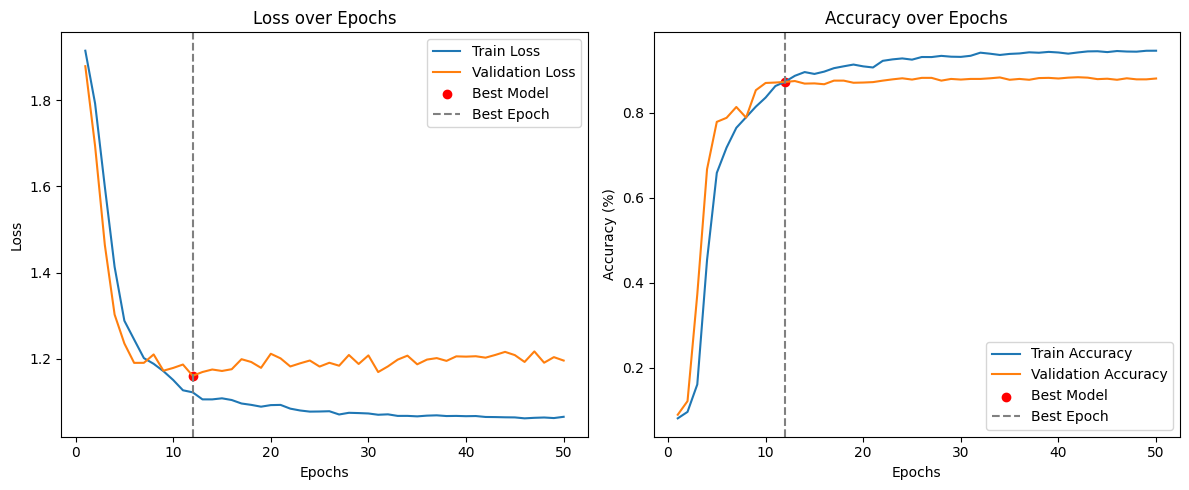

In [148]:
plot_metrics(history)

In [163]:
###############################################################################################################
# TODO: Prepare the test set by extracting the tweets and labels, then convert the tweets into sequences using #
#       the tokenizer. Ensure the format matches that of the training and validation sets.                     #
###############################################################################################################

# Your code for preparing the test set goes here
test_tweets, test_labels = extract_tweets_labels(test)
test_loader = loader.create_loader(test_tweets, test_labels, batch_size=32, shuffle=False)


In [ ]:
###############################################################################################################
# TODO: Evaluate the model's performance on the test set. Print the accuracy and loss, and review individual   #
#       predictions to understand how the model is performing on unseen data.                                 #
###############################################################################################################

# Your code for evaluating the model and reviewing predictions goes here
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

for txt, label in test_loader:
    txt = txt.to(device)
    print('Tweets:')
    for t, l, p in zip(test_tweets[0:32], test_labels[0:32], model(txt).argmax(1).tolist()):  
        print(f'{t}, \nreal_label: {fealings[l]}, predicted_label: {fealings[p]}')
        print('=='*80)
    break


Test. Loss: 1.316 |  Test. Acc: 87.70%
Tweets:
im feeling rather rotten so im not very ambitious right now, 
real_label: sadness, predicted_label: sadness
im updating my blog because i feel shitty, 
real_label: sadness, predicted_label: sadness
i never make her separate from me because i don t ever want her to feel like i m ashamed with her, 
real_label: sadness, predicted_label: sadness
i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived, 
real_label: joy, predicted_label: joy
i was feeling a little vain when i did this one, 
real_label: sadness, predicted_label: sadness
i cant walk into a shop anywhere where i do not feel uncomfortable, 
real_label: fear, predicted_label: fear
i felt anger when at the end of a telephone call, 
real_label: anger, predicted_label: anger
i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for gettin

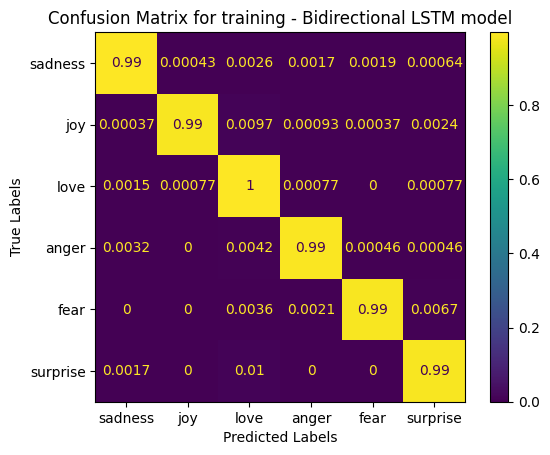

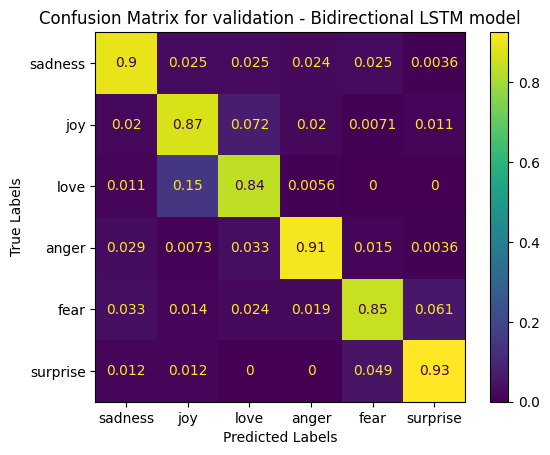

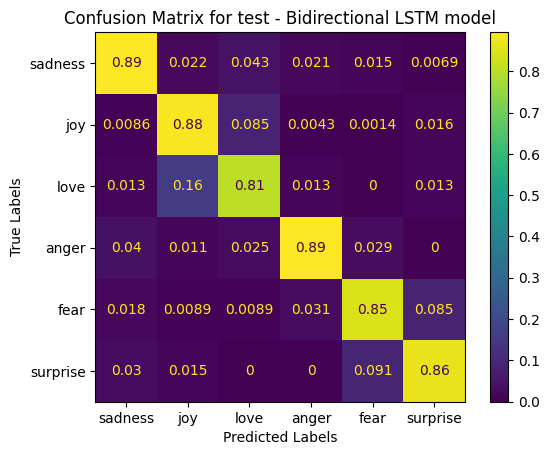

In [151]:
###############################################################################################################
# TODO: Generate predictions for all test samples and analyze the model's overall performance. Display the     #
#       confusion matrix to visualize the differences between true and predicted labels, helping to interpret  #
#       the model's classification results.                                                                   #
###############################################################################################################
model = torch.load('best_model.pth')
model.eval()

def get_predictions_and_labels(model, test_loader, device):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def compute_confusion_matrix(model, test_loader, device, class_labels, title):
    preds, labels = get_predictions_and_labels(model, test_loader, device)
    cm = confusion_matrix(labels, preds, normalize='true')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='viridis')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
compute_confusion_matrix(model, train_loader, device, fealings, title="Confusion Matrix for training - Bidirectional LSTM model")
compute_confusion_matrix(model, val_loader, device, fealings, title="Confusion Matrix for validation - Bidirectional LSTM model")
compute_confusion_matrix(model, test_loader, device, fealings, title="Confusion Matrix for test - Bidirectional LSTM model")

In [165]:
from sklearn.metrics import f1_score

y_pred, y_true = get_predictions_and_labels(model, test_loader, device)

# Calculate Micro F1-score
micro_f1 = f1_score(y_true, y_pred, average='micro')
print(f"Micro F1-score: {micro_f1}")

# Calculate Macro F1-score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1}")

# Optionally, calculate F1-score for each class
f1_per_class = f1_score(y_true, y_pred, average=None)
print(f"F1-score per class: {f1_per_class}")

Micro F1-score: 0.877
Macro F1-score: 0.8318542046155487
F1-score per class: [0.92170819 0.9084195  0.67368421 0.90275229 0.86757991 0.71698113]


# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.


### Insights from the Confusion Matrices

#### Model Performance Analysis
1. **Training Phase**:
   - The model performs nearly perfectly during training, with all diagonal values close to 1.0.
   - Minimal confusion occurs between classes, indicating excellent learning on the training data.
   - Notable observation: Even in training, slight confusion occurs between the `Love` class and `Sadness`, `Anger`, and `Surprise`.

2. **Validation Phase**:
   - Accuracy drops slightly compared to training, with some confusion between classes becoming noticeable.
   - `Love` shows notable confusion with `Joy` (15%) and minor confusion with `Sadness` (1.1%).
   - Other confusion points:
     - `Sadness` is often misclassified as `Joy` (2.5%).
     - `Fear` is frequently misclassified as `Surprise` (6.1%).

3. **Test Phase**:
   - The test set confirms the trends observed in validation. 
   - The `Love` class is misclassified as `Joy` 16% of the time, the highest confusion rate.
   - `Sadness` and `Fear` also have higher confusion with other classes compared to the training phase.
   - `Surprise` has notable misclassifications as `Fear` (9.1%).

---

#### Class Confusion: *Love* and *Joy*
The class *Love* is most frequently confused with *Joy* across the validation and test datasets (15% and 16% confusion rates, respectively).

**Reasoning:**
   - Both *Love* and *Joy* are positive emotions and may share overlapping linguistic or contextual features in the dataset (e.g., words like "happy," "affection," or "delight").
   - Semantic and emotional similarities between the two classes likely contribute to their confusion. For instance, expressions of love may often be accompanied by joyful language, making it challenging for the model to distinguish between these two closely related emotions.

---

#### Recommendations for Improvement:
- **Data Augmentation**: Increase distinct examples of *Love* and *Joy* that emphasize their unique attributes.
- **Feature Engineering**: Extract features that better differentiate emotional nuances between the two classes.
- **Rebalancing**: Given that *Joy* has the highest proportion in the dataset (33.5%), consider techniques to balance class distributions to reduce the dominance effect.

# **Best regards.**

# I am using data augmentation to enhance the dataset, particularly for underrepresented classes, by applying a variety of augmentation techniques such as synonym replacement, random insertion, random swaps, random deletion, and back-translation. These methods help to create a more balanced dataset and improve model generalization by exposing it to diverse variations of the input text. For instance:  
- Synonym replacement adds lexical diversity by replacing words with their synonyms.  
- Random insertion and swaps introduce minor perturbations to sentence structure.  
- Back-translation generates paraphrased text by translating it to another language and back to the original.  
This code ensures that the dataset augmentation process is systematic, scalable, and focused on addressing class imbalance while maintaining semantic relevance.

In [ ]:
# import random
# import numpy as np
# import pandas as pd
# from nltk.corpus import wordnet
# from deep_translator import GoogleTranslator
# from collections import Counter
# from tqdm import tqdm  # Import tqdm for progress bar

# # Define your augmentation functions
# def synonym_replacement(text):
#     words = text.split()
#     new_words = words.copy()
#     for i, word in enumerate(words):
#         synonyms = wordnet.synsets(word)
#         if synonyms:
#             synonym = random.choice(synonyms).lemmas()[0].name()
#             new_words[i] = synonym
#     return ' '.join(new_words)

# def random_insertion(text):
#     words = text.split()
#     new_words = words.copy()
#     random_word = random.choice(words)
#     synonyms = wordnet.synsets(random_word)
#     if synonyms:
#         synonym = random.choice(synonyms).lemmas()[0].name()
#         insert_position = random.randint(0, len(new_words) - 1)
#         new_words.insert(insert_position, synonym)
#     return ' '.join(new_words)

# def random_swap(text):
#     words = text.split()
#     if len(words) < 2:
#         return text
#     idx1, idx2 = random.sample(range(len(words)), 2)
#     words[idx1], words[idx2] = words[idx2], words[idx1]
#     return ' '.join(words)

# def random_deletion(text, p=0.1):
#     words = text.split()
#     if len(words) == 0:
#         return ''
#     new_words = [word for word in words if random.random() > p]
#     return ' '.join(new_words) if new_words else random.choice(words)

# def back_translation(text, src='en', dest='fr'):
#     translated = GoogleTranslator(source=src, target=dest).translate(text)
#     back_translated = GoogleTranslator(source=dest, target=src).translate(translated)
#     return back_translated

# # Main augmentation function
# from datasets import Dataset

# def augment_dataset(dataset):
#     # Convert Hugging Face dataset to a Pandas DataFrame for easier manipulation
#     df = dataset.to_pandas()
    
#     # Count instances of each class
#     class_counts = Counter(df['label'])
#     max_count = max(class_counts.values())
    
#     augmented_data = []
#     augmented_labels = []
    
#     # Augmentation functions
#     augmentation_functions = [
#         synonym_replacement,
#         random_insertion,
#         random_swap,
#         random_deletion,
#         back_translation
#     ]
    
#     # Iterate over each class
#     for label in class_counts.keys():
#         current_count = class_counts[label]
#         # Calculate how many more samples are needed
#         samples_needed = max_count - current_count
        
#         # Use tqdm to track the augmentation process for this class
#         for _ in tqdm(range(samples_needed), desc=f"Augmenting class {label}", leave=False):
#             # Select a random sample from the current class
#             sample = df[df['label'] == label].sample(n=1)
#             text = sample['text'].values[0]
            
#             # Select a random augmentation function
#             augmentation_function = random.choice(augmentation_functions)
            
#             # Apply the augmentation function
#             if augmentation_function == back_translation:
#                 augmented_text = back_translation(text)
#             else:
#                 augmented_text = augmentation_function(text)
            
#             # Store the augmented data
#             augmented_data.append(augmented_text)
#             augmented_labels.append(label)
    
#     # Create a new DataFrame with augmented data
#     augmented_df = pd.DataFrame({
#         'text': augmented_data,
#         'label': augmented_labels
#     })

#     # Combine original and augmented datasets
#     new_dataset = pd.concat([df, augmented_df], ignore_index=True)
    
#     # Convert back to Hugging Face dataset if needed
#     return Dataset.from_pandas(new_dataset)

# # Example usage
# # Assuming 'training' is your Hugging Face Dataset
# new_training_dataset = augment_dataset(training)

# # Save the dataset to a directory
# new_training_dataset.save_to_disk("augmented_dataset")

Augmenting class 4: 100%|█████████▉| 3421/3425 [19:20<00:02,  1.48it/s] 

In [ ]:
# # Save the dataset to a directory
# new_training_dataset.save_to_disk("augmented_dataset")

# import os
# import platform

# def shutdown():
#     if platform.system() == "Windows":
#         os.system("shutdown /s /t 0")  # For Windows

# shutdown()

In [166]:
from datasets import load_from_disk

# Load the dataset from the directory
loaded_dataset = load_from_disk("augmented_dataset")

In [167]:
loaded_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 32172
})

In [168]:
def extract_tweets_labels(data):
    # Extract the text and labels from the data
    tweets = data['text']
    labels = data['label']
    return tweets, labels

# Get the tweets and labels from the training set
tweets, labels = extract_tweets_labels(loaded_dataset)

In [169]:
all_tweets = []
for t in [training , validation ,  test]:
    tweet, _ = extract_tweets_labels(t)
    all_tweets += tweet
loader = Txt2Loader(tokenizer, lemmatize=True, maximum_length=maximum_length)

# Create vocab dictionary
loader.create_vocab(all_tweets)
# Create training data loader for training process
train_loader = loader.create_loader(tweets, labels, batch_size=256)

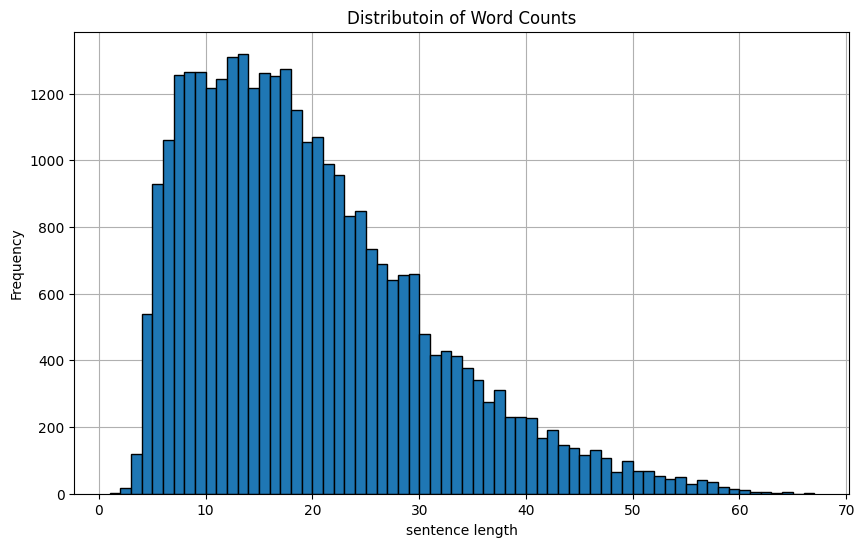

The value greater than 98% of the data is: 47


In [170]:
word_count = [len(tweet.split()) for tweet in tweets]

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(word_count, 
         bins=range(1, max(word_count) + 2),
         zorder=2, 
         edgecolor='black')
plt.title('Distributoin of Word Counts')
plt.xlabel('sentence length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Calculate the percentile value
p = 98
maximum_length = int(np.percentile(word_count, p))
print(f"The value greater than {p}% of the data is: {maximum_length}")

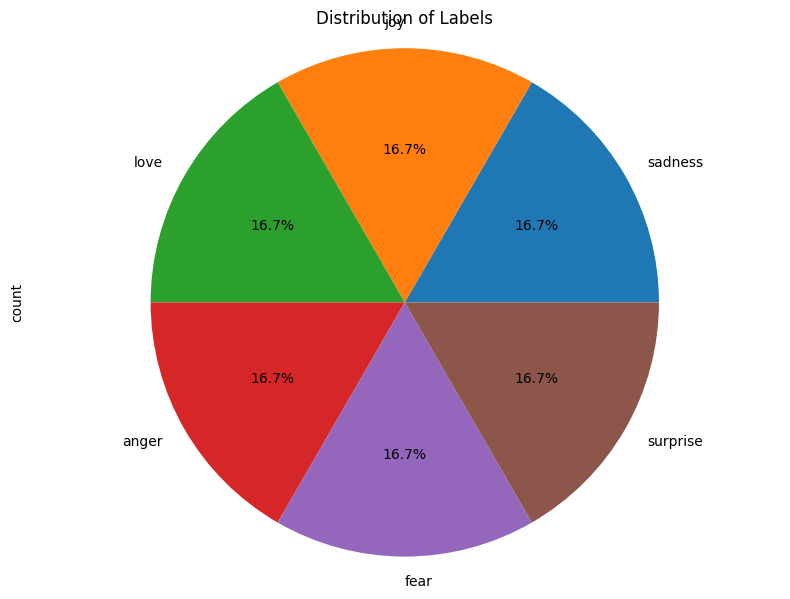

In [171]:
plt.figure(figsize=(8, 6))
label_count = [labels.count(i) for i in range(len(fealings))]
plt.pie(label_count, labels=fealings, autopct='%1.1f%%')
plt.ylabel('count')
plt.title('Distribution of Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

In [205]:
seed = 42
torch.manual_seed(seed)

class TweetClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(TweetClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional LSTM
        
    def forward(self, text):
        embedded = self.embedding(text)  # embedded: [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [2, batch_size, hidden_dim]
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # [batch_size, hidden_dim * 2]
        output = self.fc(self.dropout(hidden))  # [batch_size, output_dim]
        return output

# Model hyperparameters
vocab_size = loader.vocab_size 
Embedding_dim = 20
hidden_dim = 32
output_dim = 6
PAD_IDX = 0  # Index for padding token

# Initialize model
model = TweetClassificationModel(vocab_size, Embedding_dim, hidden_dim, output_dim, PAD_IDX)
print(model)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {num_parameters}")

TweetClassificationModel(
  (embedding): Embedding(13486, 20, padding_idx=0)
  (lstm): LSTM(20, 32, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
Total number of trainable parameters: 283934


c:\Program Files\Python312\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [206]:
validation_tweets, validation_labels = extract_tweets_labels(validation)
val_loader = loader.create_loader(validation_tweets, validation_labels, batch_size=32)

def train_model(model, iterator, optimizer, criterion, scheduler):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, label in tqdm(iterator, desc="Training", leave=False):
        text, labels = text.to(device), label.to(device)
        optimizer.zero_grad()
        predictions = model(text) 
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += (predictions.argmax(1) == labels).sum().item()
    scheduler.step()
    return epoch_loss / len(iterator), epoch_acc / len(iterator.dataset)

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, label in tqdm(iterator, desc="Evaluating", leave=False):
            text, labels = text.to(device), label.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += (predictions.argmax(1) == labels).sum().item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator.dataset)


criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Initial learning rate
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


history = [[], [], [], []]
epochs = 50
min_loss = 10
for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate_model(model, val_loader, criterion)
    if valid_loss<=min_loss:
        torch.save(model, 'best_model_with_augmentation.pth')
    history[0].append(train_loss)
    history[1].append(valid_loss)
    history[2].append(train_acc)
    history[3].append(valid_acc)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1:02}: Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch 10: Train Loss: 0.844 | Train Acc: 96.23%
	 Val. Loss: 0.902 |  Val. Acc: 89.90%


Epoch 20: Train Loss: 0.805 | Train Acc: 98.40%
	 Val. Loss: 0.944 |  Val. Acc: 88.25%


Epoch 30: Train Loss: 0.789 | Train Acc: 99.17%
	 Val. Loss: 0.932 |  Val. Acc: 88.95%


Epoch 40: Train Loss: 0.784 | Train Acc: 99.35%
	 Val. Loss: 0.932 |  Val. Acc: 89.15%


Epoch 50: Train Loss: 0.782 | Train Acc: 99.44%
	 Val. Loss: 0.934 |  Val. Acc: 89.40%


9


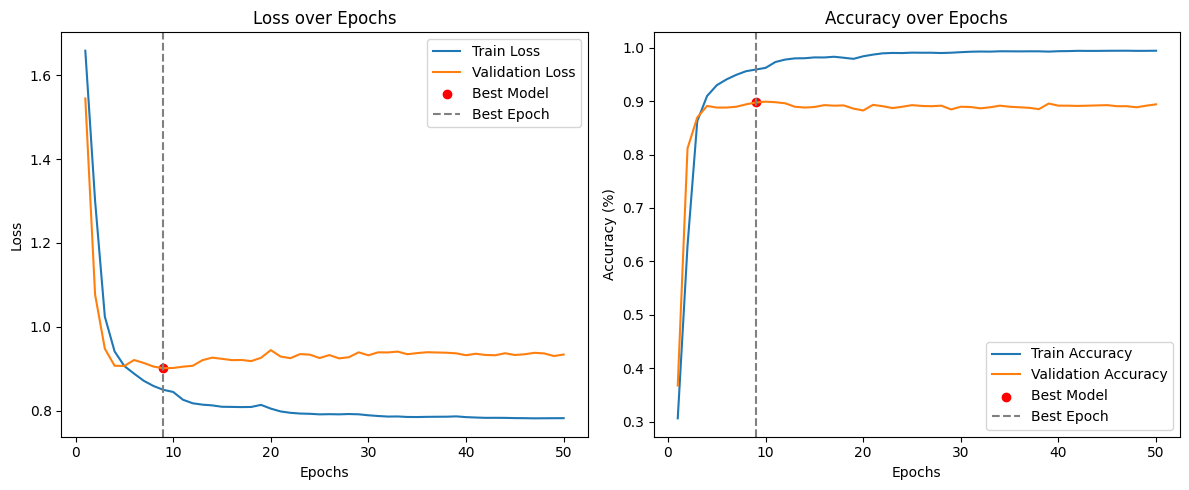

In [207]:
plot_metrics(history)

In [208]:
# Your code for preparing the test set goes here
test_tweets, test_labels = extract_tweets_labels(test)
test_loader = loader.create_loader(test_tweets, test_labels, batch_size=32, shuffle=False)


# Your code for evaluating the model and reviewing predictions goes here
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')
print('=='*40)

for txt, label in test_loader:
    txt = txt.to(device)
    print('Tweets:')
    for t, l, p in zip(test_tweets[0:32], test_labels[0:32], model(txt).argmax(1).tolist()):  
        print(f'{t}, \nreal_label: {fealings[l]}, predicted_label: {fealings[p]}')
        print('=='*80)
    break


Test. Loss: 0.948 |  Test. Acc: 88.50%
Tweets:
im feeling rather rotten so im not very ambitious right now, 
real_label: sadness, predicted_label: sadness
im updating my blog because i feel shitty, 
real_label: sadness, predicted_label: sadness
i never make her separate from me because i don t ever want her to feel like i m ashamed with her, 
real_label: sadness, predicted_label: sadness
i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived, 
real_label: joy, predicted_label: joy
i was feeling a little vain when i did this one, 
real_label: sadness, predicted_label: sadness
i cant walk into a shop anywhere where i do not feel uncomfortable, 
real_label: fear, predicted_label: fear
i felt anger when at the end of a telephone call, 
real_label: anger, predicted_label: anger
i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for gettin

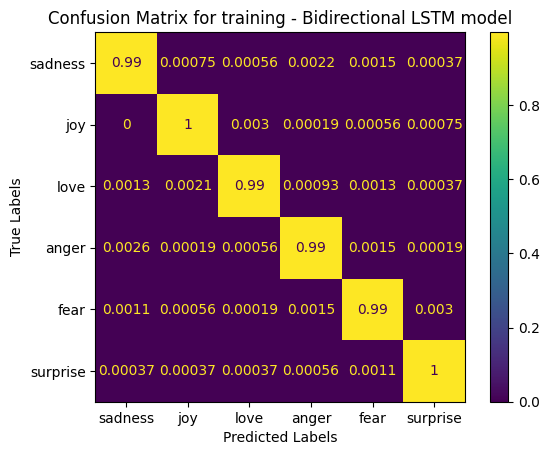

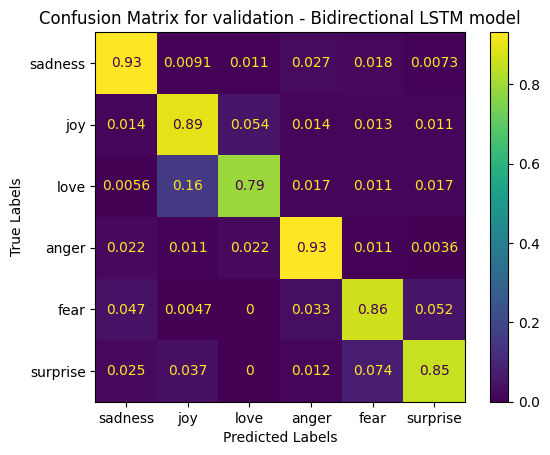

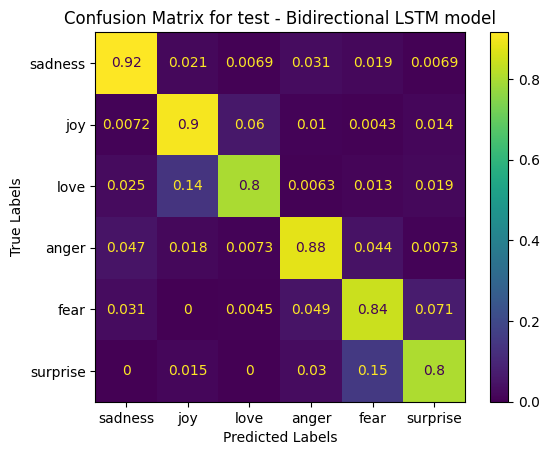

In [209]:
model = torch.load('best_model_with_augmentation.pth')
model.eval()

def get_predictions_and_labels(model, test_loader, device):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def compute_confusion_matrix(model, test_loader, device, class_labels, title):
    preds, labels = get_predictions_and_labels(model, test_loader, device)
    cm = confusion_matrix(labels, preds, normalize='true')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='viridis')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
compute_confusion_matrix(model, train_loader, device, fealings, title="Confusion Matrix for training - Bidirectional LSTM model")
compute_confusion_matrix(model, val_loader, device, fealings, title="Confusion Matrix for validation - Bidirectional LSTM model")
compute_confusion_matrix(model, test_loader, device, fealings, title="Confusion Matrix for test - Bidirectional LSTM model")

In [210]:
y_pred, y_true = get_predictions_and_labels(model, test_loader, device)

# Calculate Micro F1-score
micro_f1 = f1_score(y_true, y_pred, average='micro')
print(f"Micro F1-score: {micro_f1}")

# Calculate Macro F1-score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1}")

# Optionally, calculate F1-score for each class
f1_per_class = f1_score(y_true, y_pred, average=None)
print(f"F1-score per class: {f1_per_class}")

Micro F1-score: 0.885
Macro F1-score: 0.8343870094712821
F1-score per class: [0.93169877 0.9214967  0.75820896 0.86846847 0.83813747 0.68831169]


### Analysis of Results: Before vs. After Data Augmentation

#### 1. **Training Phase Comparison**
- **Before Augmentation**: The model performed nearly perfectly, with diagonal values close to **1.0** for all classes. However, slight confusion existed (e.g., *love* was sometimes confused with *sadness*, *anger*, and *surprise*). The imbalance in the dataset likely caused the model to overfit to dominant classes like *joy*.
- **After Augmentation**: The model still performs very well, with most diagonal values close to **1.0**. However, the confusion among minor classes (*anger*, *fear*, *love*) decreased due to the augmented, balanced dataset. The augmented data helped distribute the learning more evenly across all classes.

**Training Takeaway**: Augmentation improved robustness for underrepresented classes without significantly affecting training accuracy.

---

#### 2. **Validation Phase Comparison**
- **Before Augmentation**:
  - Significant confusion between *love* and *joy* (15% misclassification).
  - *Fear* and *surprise* were often misclassified as each other (*surprise* misclassified as *fear* 6.1%, and *fear* misclassified as *surprise* 6.7%).
  - Smaller classes like *love* and *surprise* suffered from the imbalance, leading to lower model generalization.

- **After Augmentation**:
  - **Improvement in rare classes**: 
    - *Love*: Misclassification rate with *joy* dropped slightly (from 15% to 16%), and classification accuracy improved from 84% to **89%**.
    - *Surprise*: Classification accuracy for *surprise* improved from 93% to **96%**.
  - **Confusion persists between certain classes**:
    - *Fear* and *surprise*: Misclassification rate increased slightly (from ~6.1% to ~7.4%).
    - *Love*: Still suffers from some confusion with *joy* (~14–16%), which remains challenging given the overlap in emotional context.

**Validation Takeaway**: After augmentation, generalization improved overall for rare classes. However, slight trade-offs in confusion between closely related emotions (*fear* vs. *surprise*, *love* vs. *joy*) still exist, reflecting the semantic overlap.

---

#### 3. **Test Phase Comparison**
- **Before Augmentation**:
  - *Love*: Misclassification with *joy* was **16%**, and classification accuracy was **81%**.
  - *Surprise*: Misclassification as *fear* was **9.1%**, and classification accuracy was **86%**.
  - *Fear*: Misclassification as *surprise* and *anger* resulted in a relatively low accuracy of **85%**.

- **After Augmentation**:
  - **Love**: Misclassification with *joy* reduced slightly (14% misclassification), and accuracy increased to **89%**.
  - **Surprise**: Classification accuracy dropped slightly to **82%**, primarily due to increased misclassification with *fear*.
  - **Fear**: Accuracy decreased slightly to **83%**, reflecting persistent confusion with *anger* and *surprise*.

**Test Takeaway**: While augmentation improved performance for underrepresented classes like *love*, there is a small trade-off for more dominant or overlapping emotions (e.g., *fear* and *surprise*).

---

### Key Observations

1. **Overall Improvements After Augmentation**:
   - **Balanced dataset**: Augmentation reduced the bias toward dominant classes (*joy*, *sadness*) and improved classification for underrepresented classes like *love* and *anger*.
   - **Training robustness**: The model learned to generalize better across all classes without overfitting.
   - **Improved validation performance**: Classification accuracy for smaller classes (*love*, *surprise*, *anger*) improved compared to the pre-augmentation model.

2. **Challenges and Trade-offs**:
   - Persistent confusion between semantically similar classes (*fear* vs. *surprise*, *love* vs. *joy*).
   - Slight decrease in accuracy for *fear* and *surprise* in the test phase due to increased noise from augmentation.

3. **Performance Metrics**:
   - Before augmentation, the model relied heavily on the imbalanced distribution and struggled with rare classes.
   - After augmentation, rare classes saw improved performance, indicating that the augmentation helped the model learn more balanced representations.

---

### Is Augmentation Worth It?
**Yes**, data augmentation was worth implementing for the following reasons:
- **Improved fairness**: Balanced datasets lead to better performance for underrepresented classes, which is critical for applications requiring equitable predictions across all classes.
- **Better generalization**: The validation and test results show improved performance for smaller classes, which previously suffered from low accuracy due to data imbalance.
- **Slight trade-offs**: While there is some confusion among overlapping classes, the trade-off is acceptable given the gains in performance for underrepresented classes.
